In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime

from matplotlib import pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import pacf, acf

from statsmodels.tsa.stattools import adfuller
from IPython.display import clear_output
from arch import arch_model
from utils import *

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('data/AAPL.csv', delimiter=',').reset_index()[['date','close']]

df['date'] = pd.to_datetime(df['date']).dt.date
df['close'] = df['close'] / np.abs(df['close']).max()
df.rename(columns={'close':'value'},inplace=True)

In [3]:
series = np.log1p(df['value'])

In [4]:
stationarity_test(series, adfuller)

{'adfuller_statistics': -1.3684429177884698,
 'adfuller_p_value': 0.597308031466917,
 'adfuller_critical_value (1%)': -3.4355964295197743,
 'adfuller_critical_value (5%)': -2.863856825923603,
 'adfuller_critical_value (10%)': -2.5680035060041626}

In [5]:
stationarity_test(series.diff(1).dropna(), adfuller)

{'adfuller_statistics': -12.044020073458533,
 'adfuller_p_value': 2.690957140849548e-22,
 'adfuller_critical_value (1%)': -3.4355964295197743,
 'adfuller_critical_value (5%)': -2.863856825923603,
 'adfuller_critical_value (10%)': -2.5680035060041626}

In [6]:
stationarity_test(series.diff(1).dropna().diff(1).dropna(), adfuller)

{'adfuller_statistics': -13.526385408482458,
 'adfuller_p_value': 2.6734909139442393e-25,
 'adfuller_critical_value (1%)': -3.435660336370594,
 'adfuller_critical_value (5%)': -2.863885022214541,
 'adfuller_critical_value (10%)': -2.568018522153254}

# Train/Test split

In [4]:
test_size = 7

train_size = (df['date'].iloc[-1] - df['date'].iloc[2]).days - test_size

print(f"Test period {test_size}\nTrain period {train_size}")

folds_indexes = list(TimeSeriesSplit(n_splits=5, test_size=test_size).split(series))
min_fold_len = min([len(fold[0]) for fold in folds_indexes])

for i in range(len(folds_indexes)):
    folds_indexes[i] = (folds_indexes[i][0][-min_fold_len:], folds_indexes[i][1])

Test period 7
Train period 1814


# ARIMA

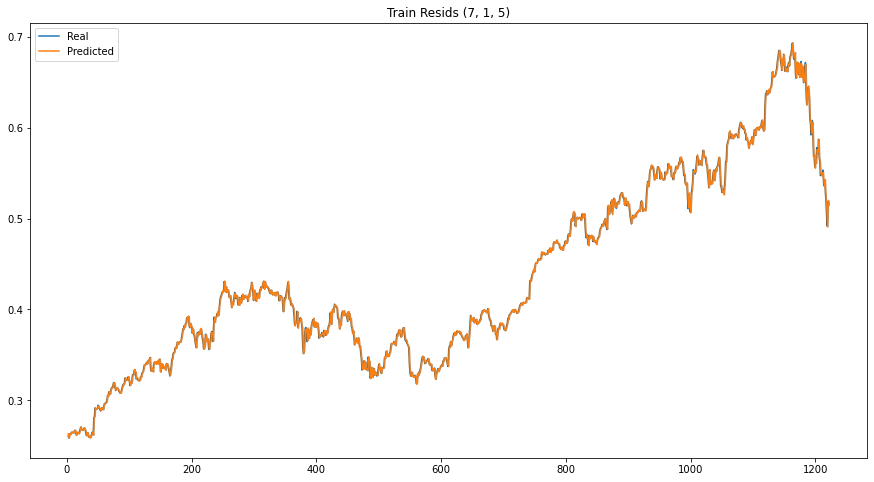

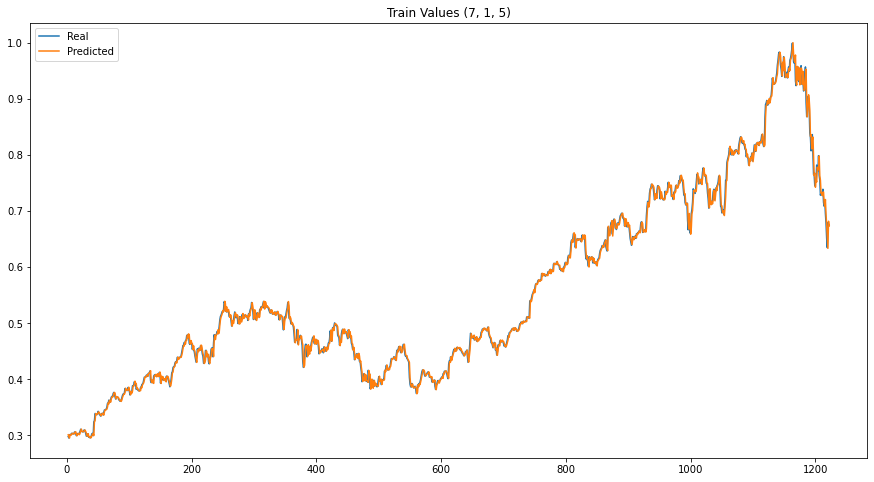

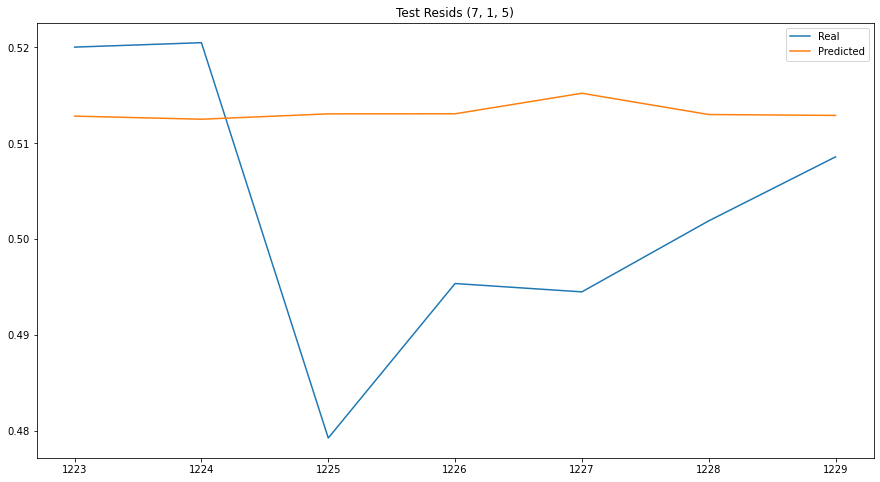

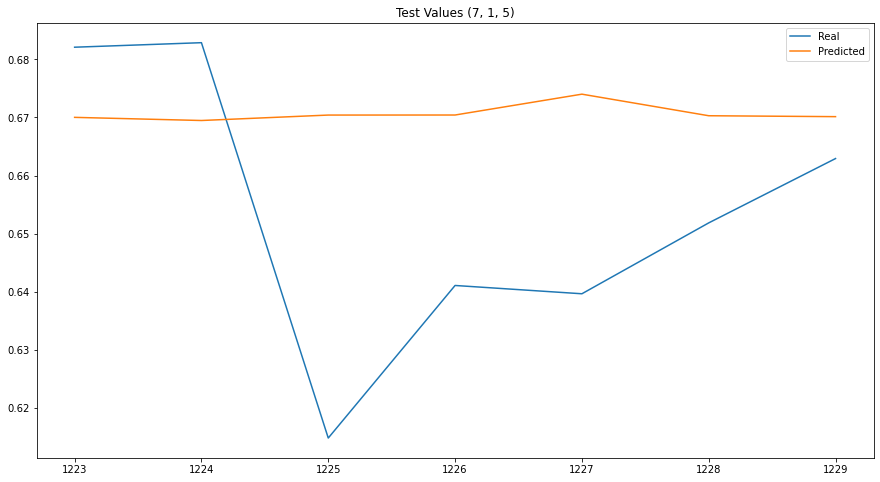

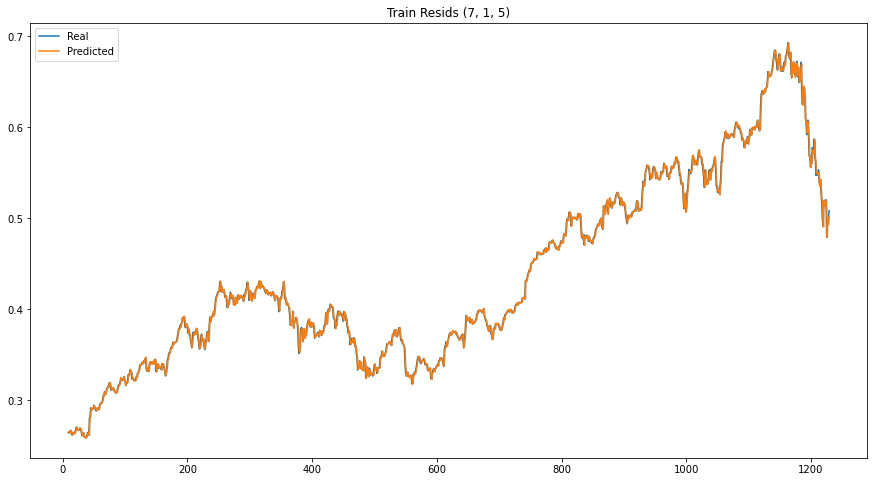

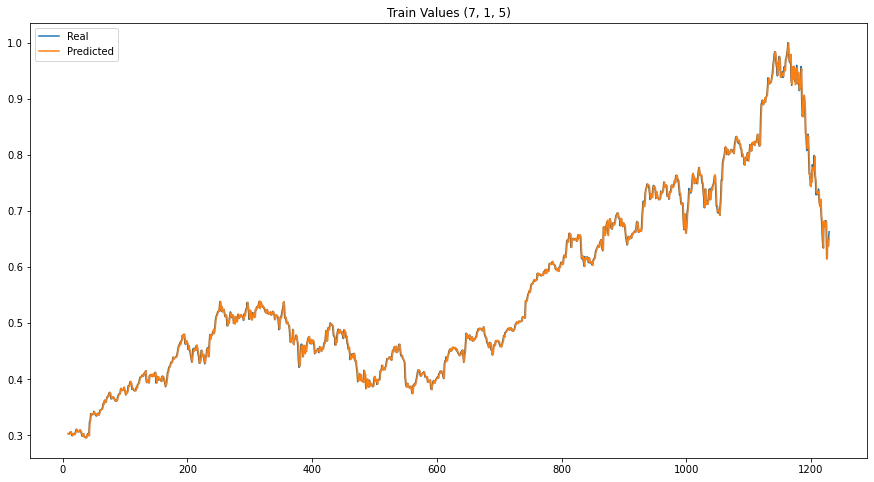

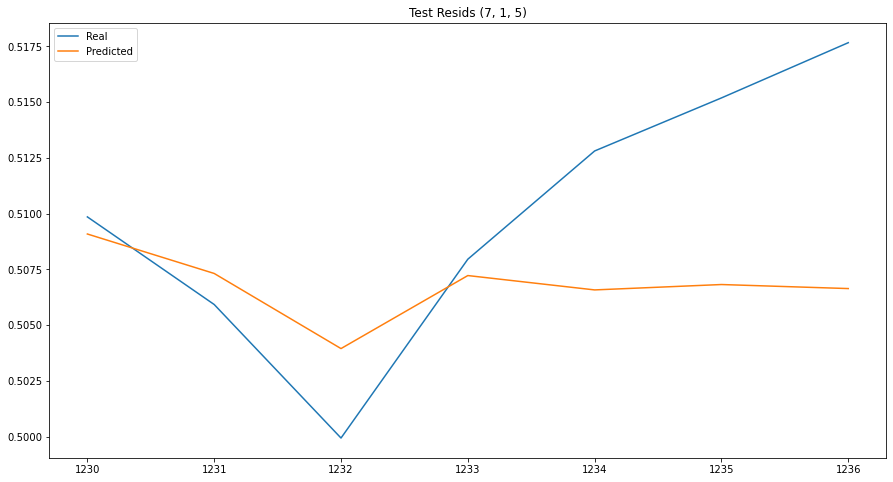

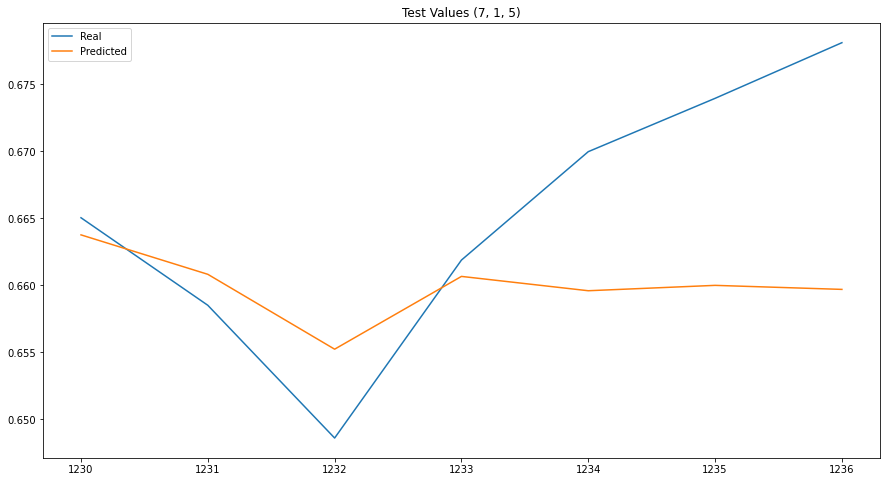

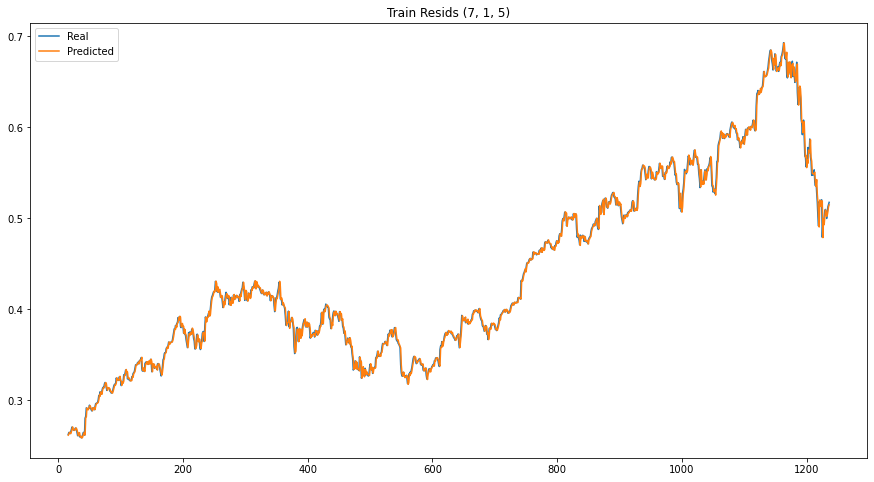

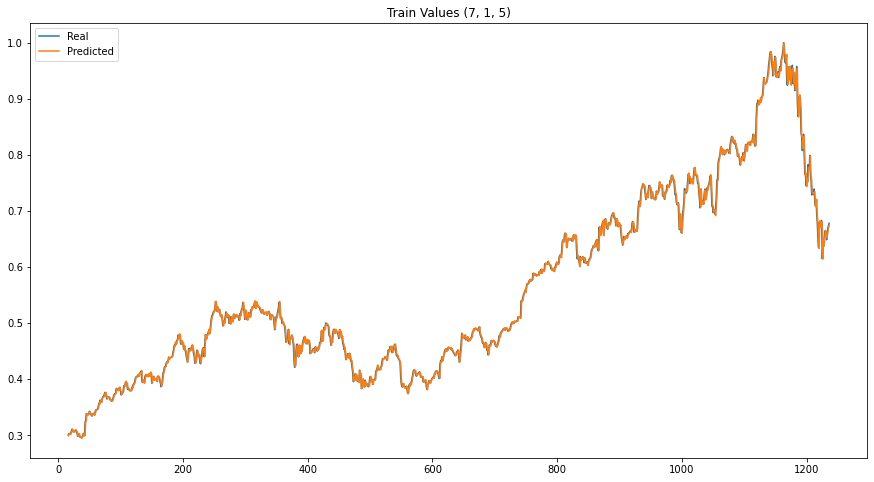

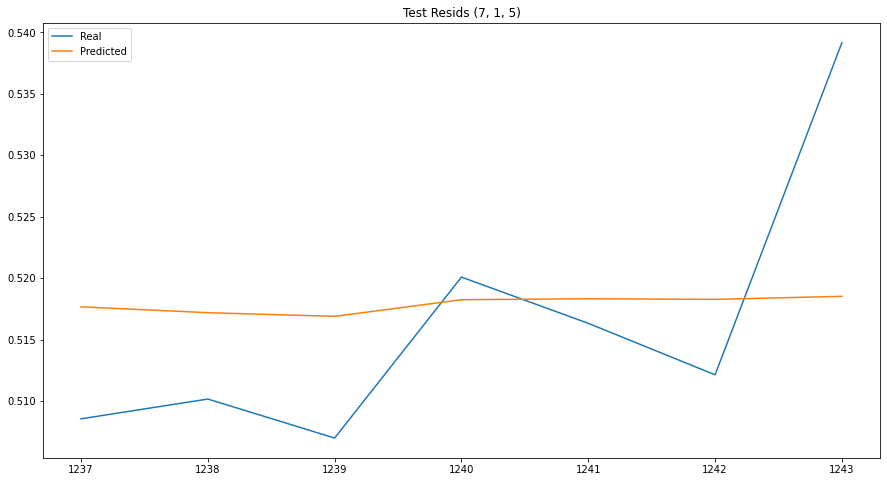

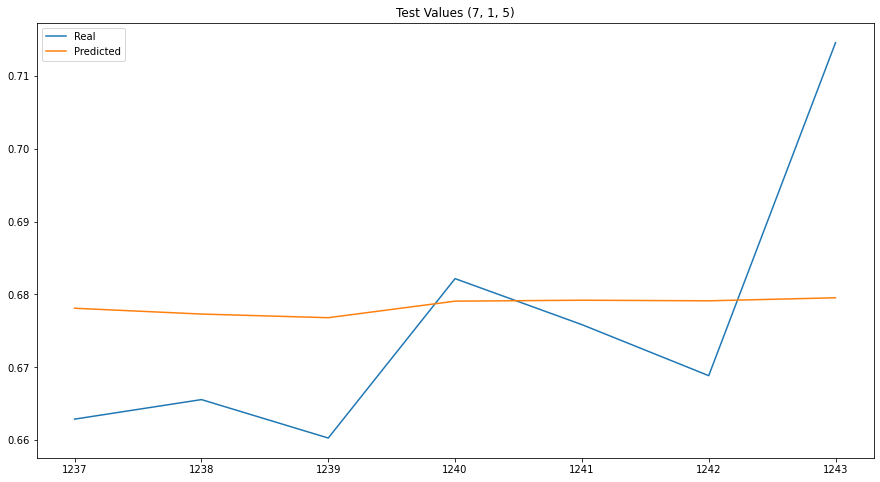

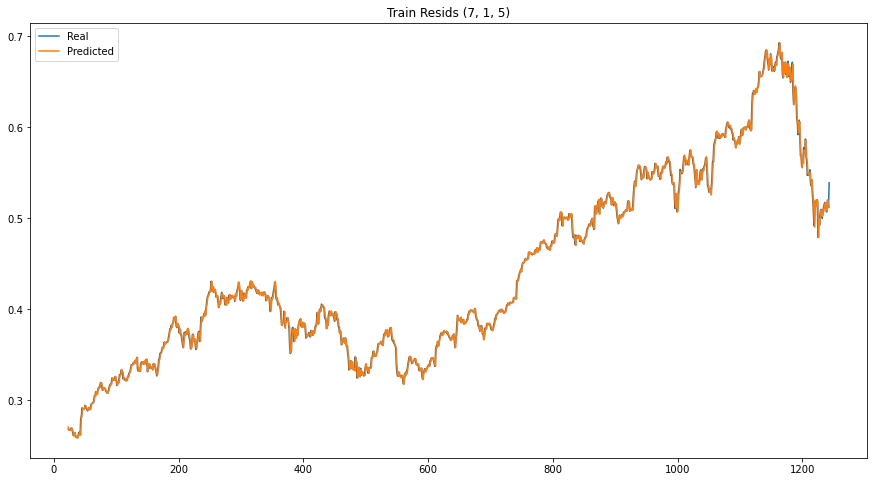

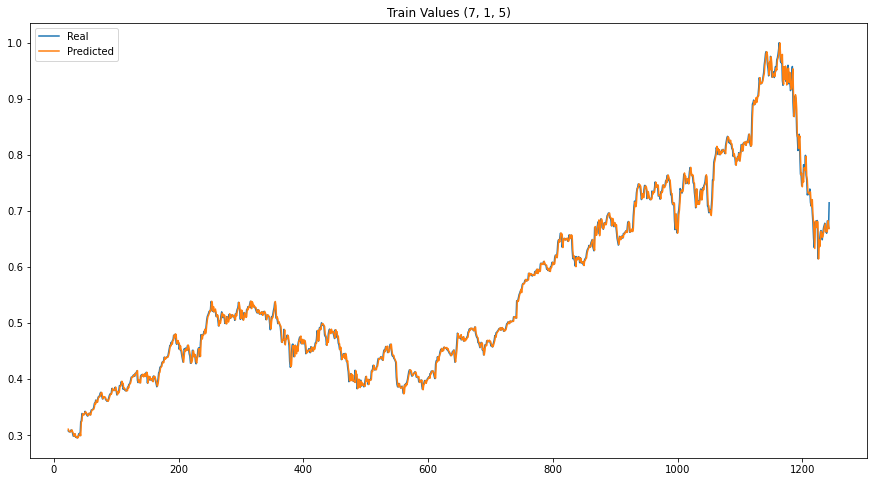

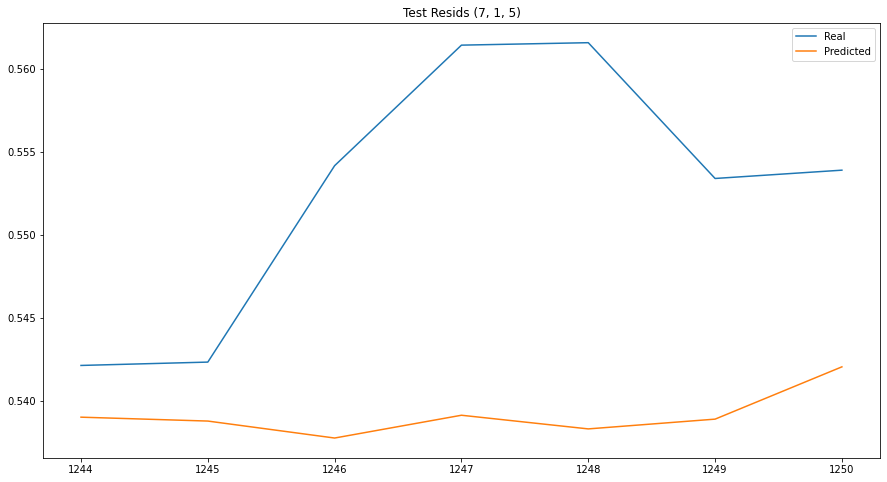

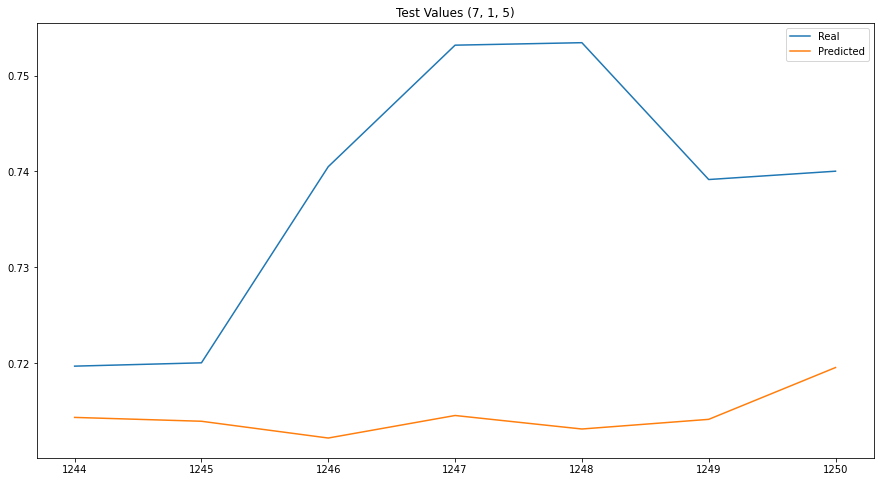

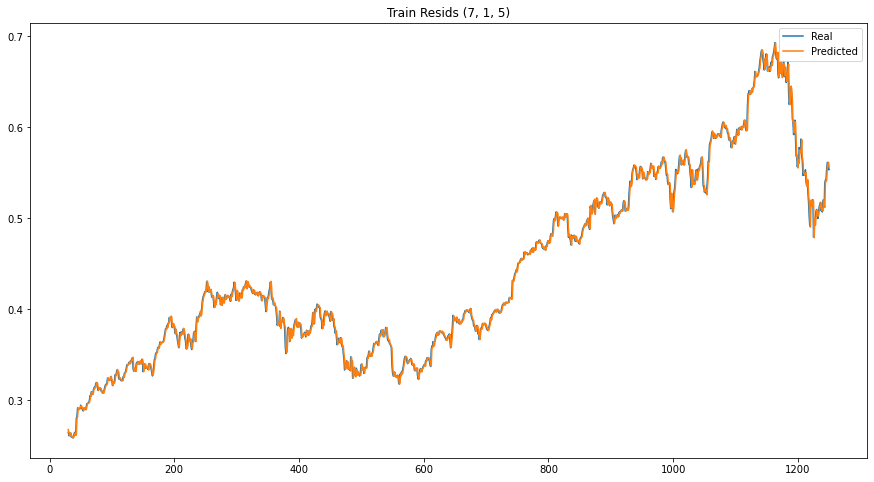

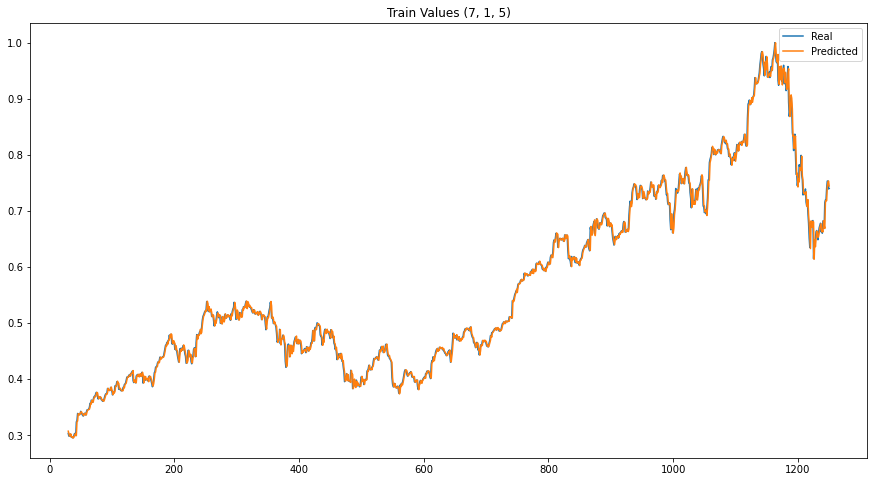

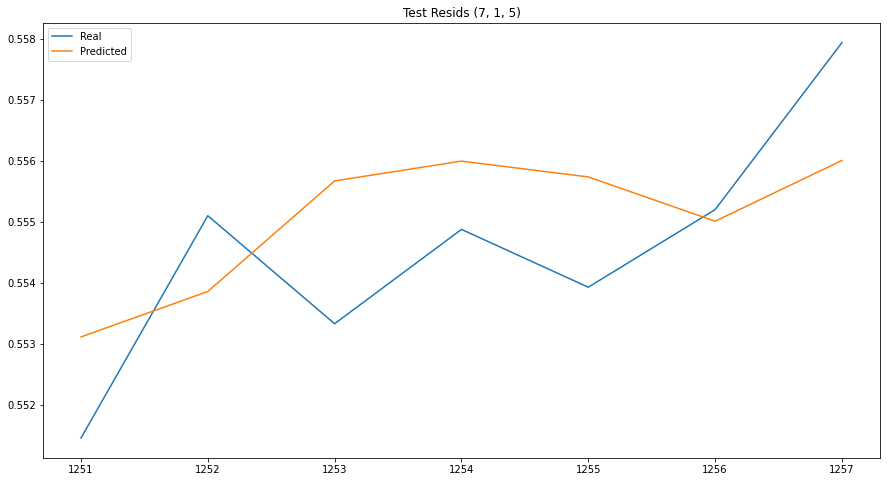

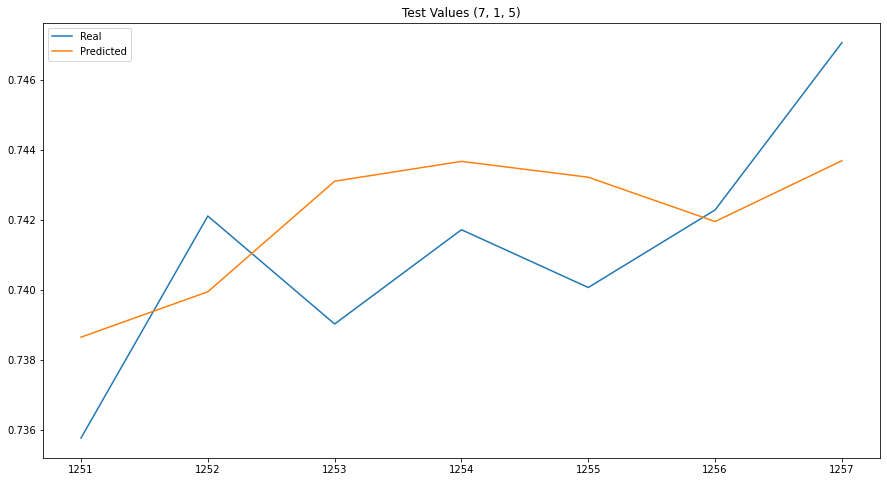

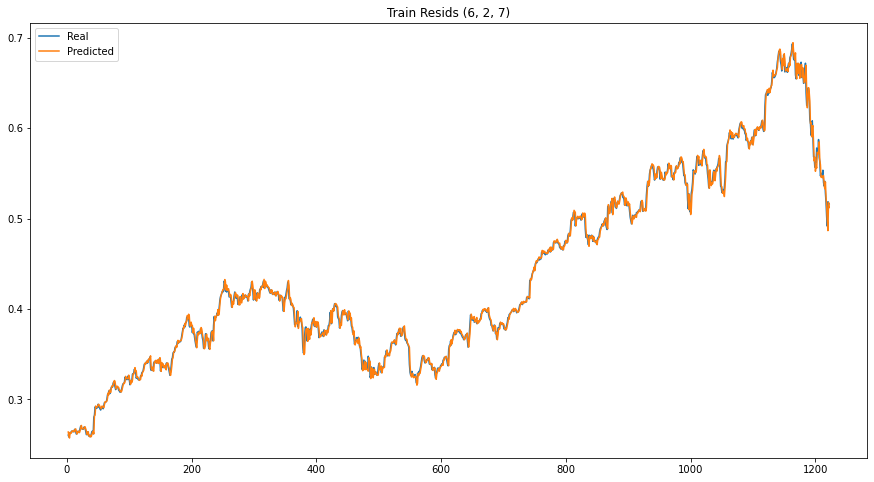

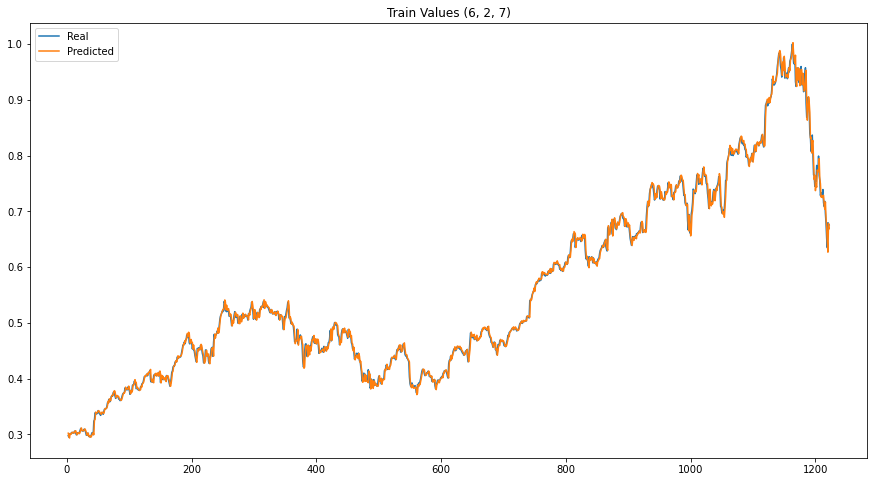

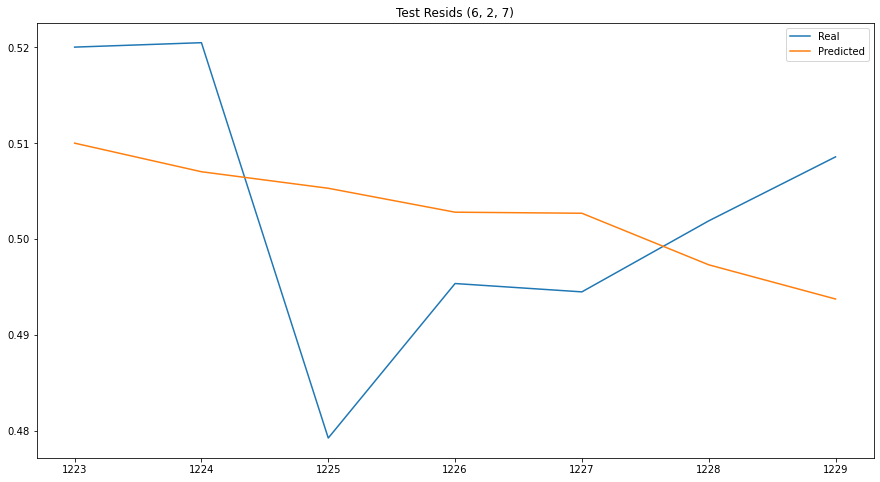

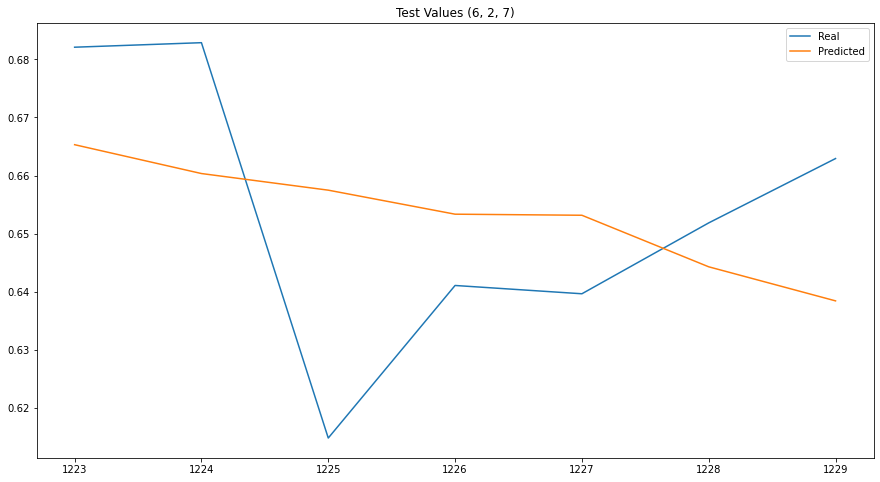

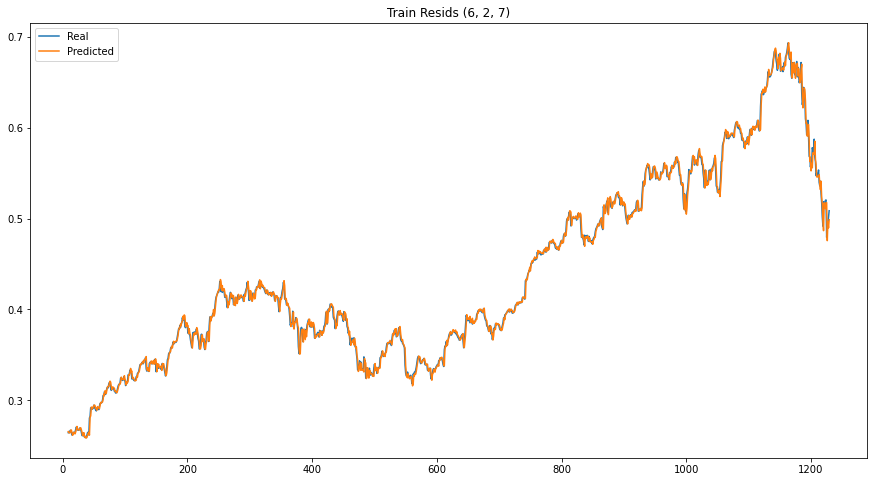

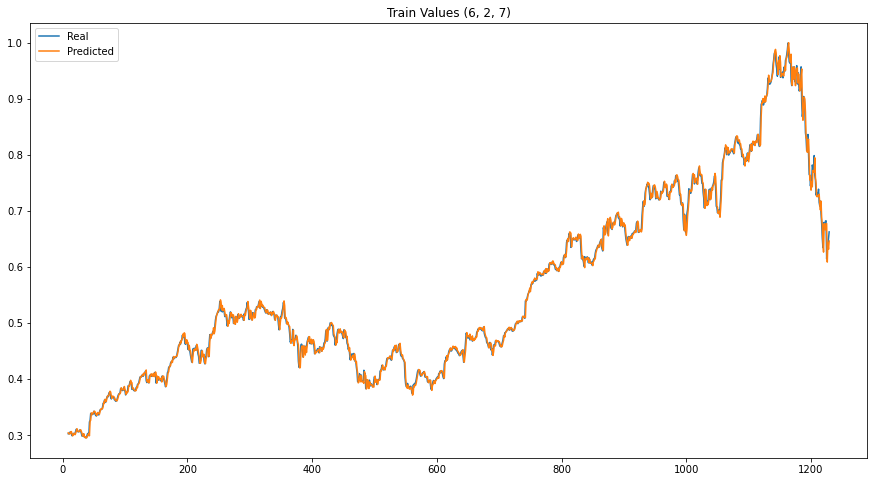

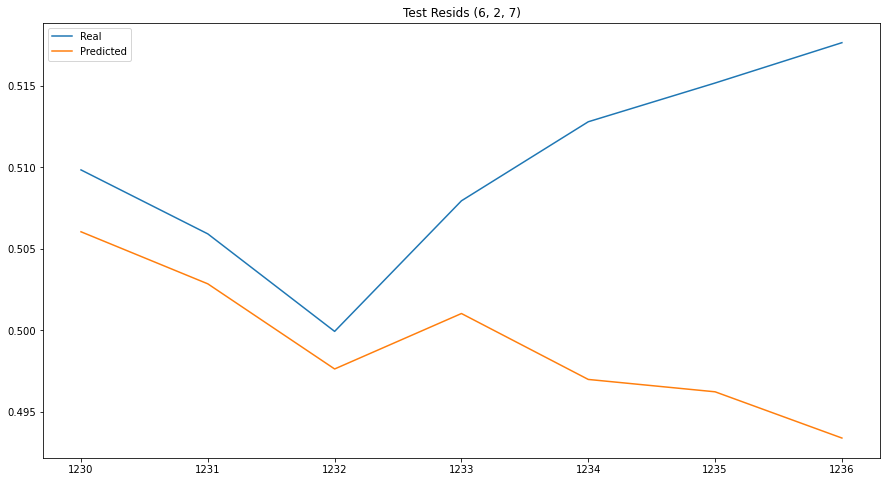

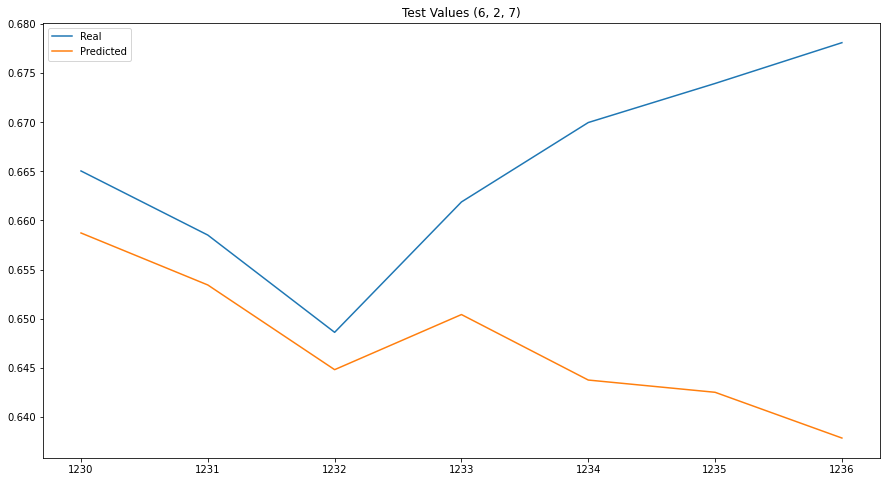

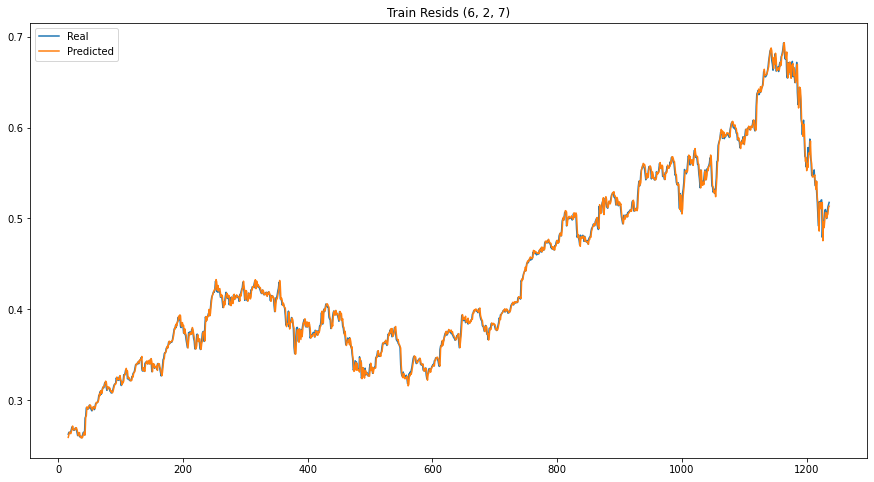

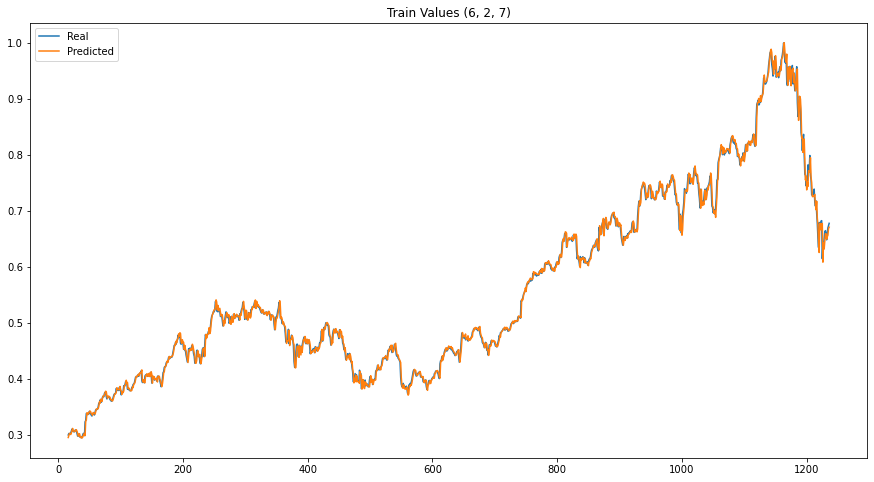

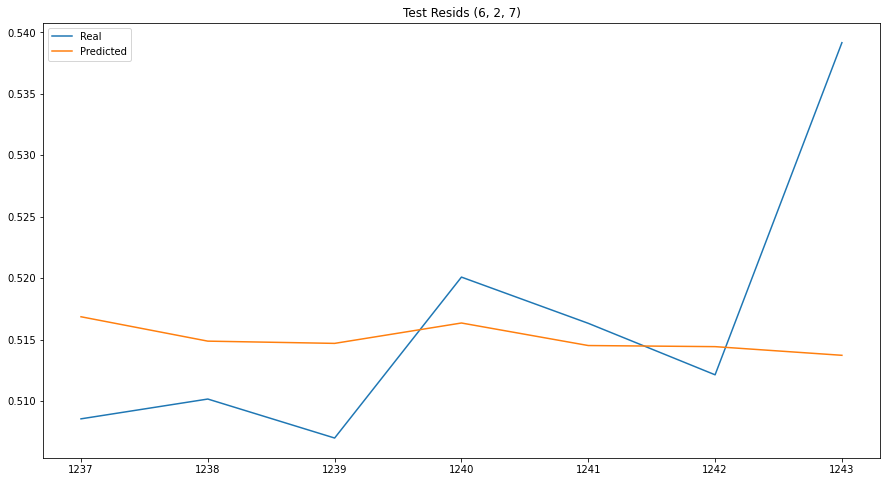

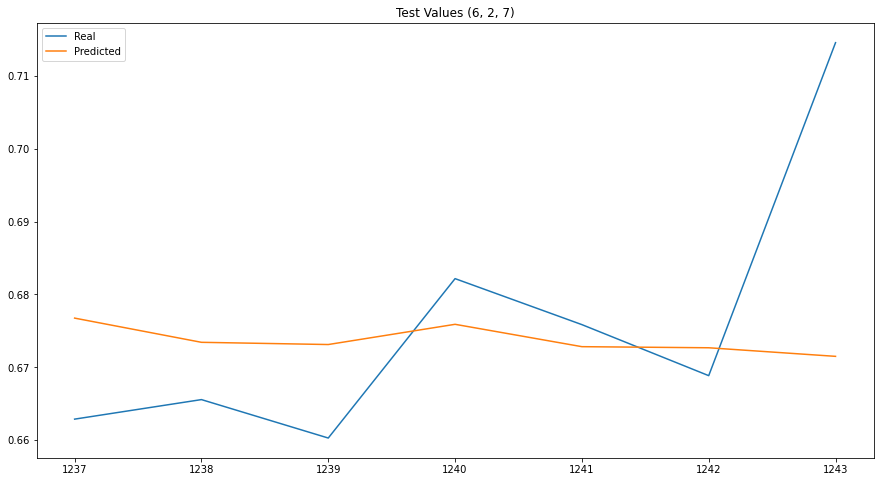

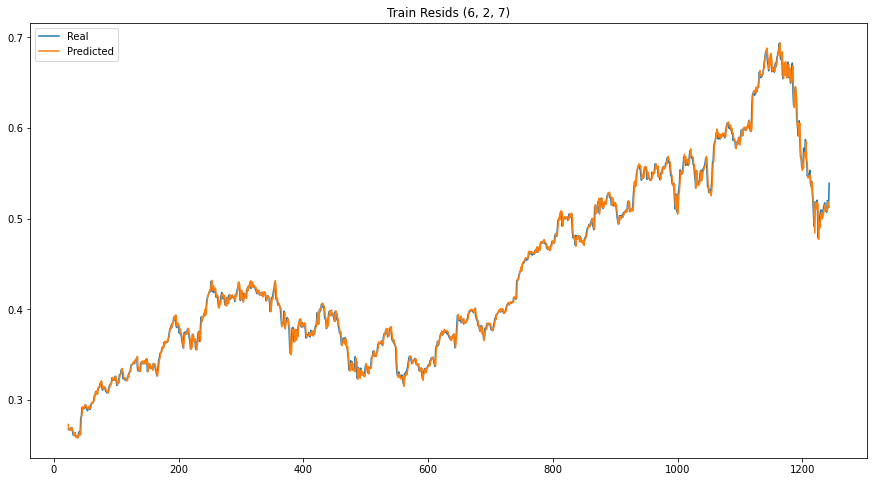

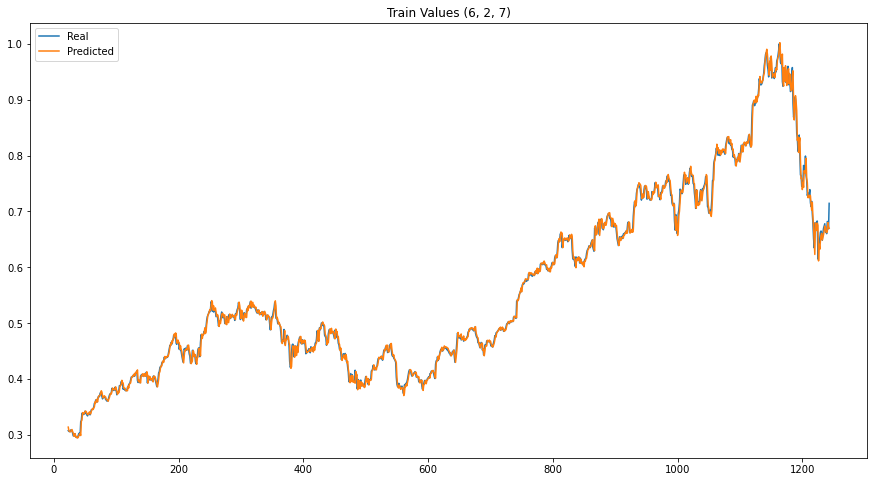

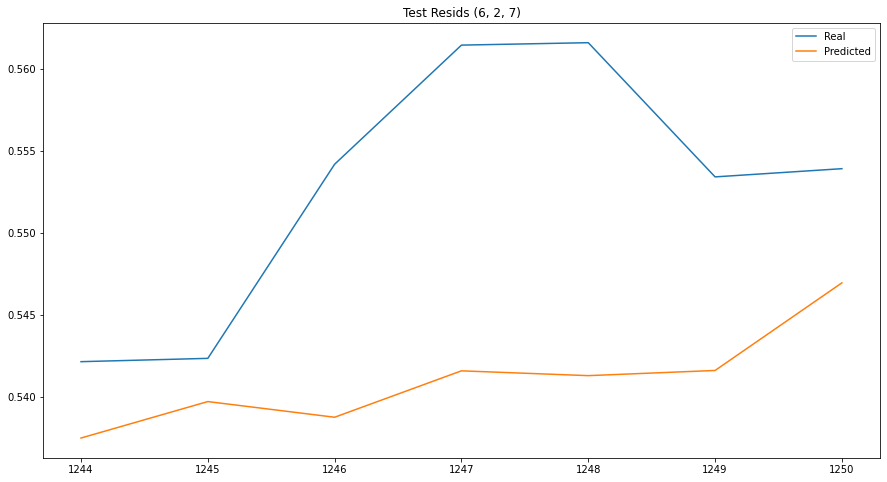

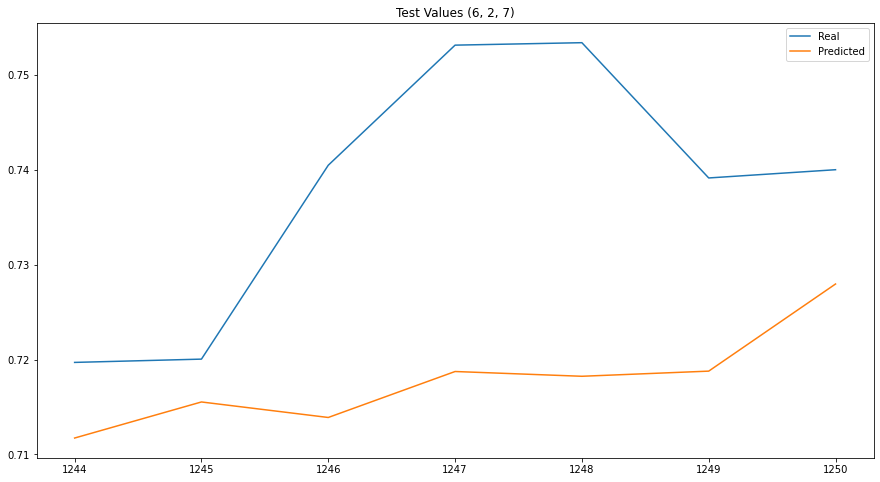

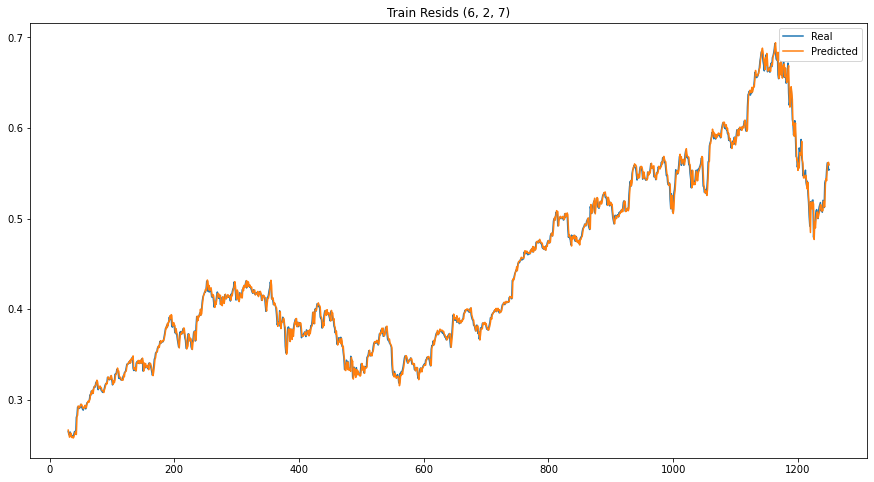

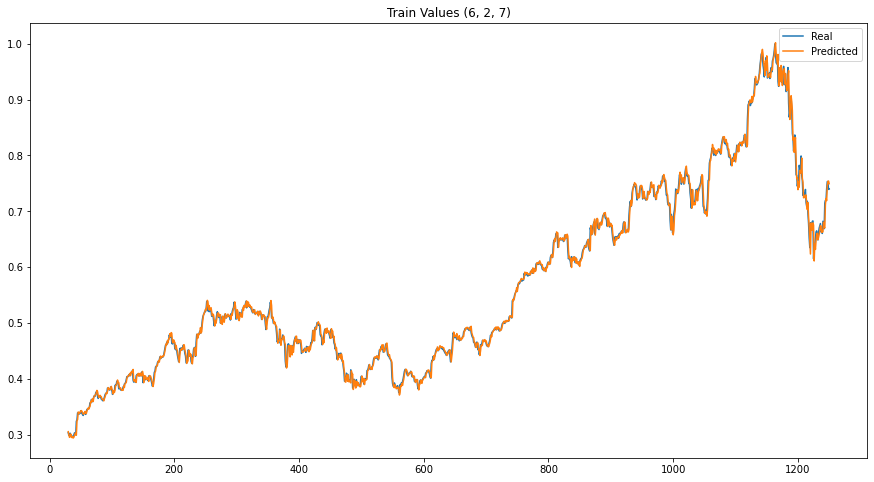

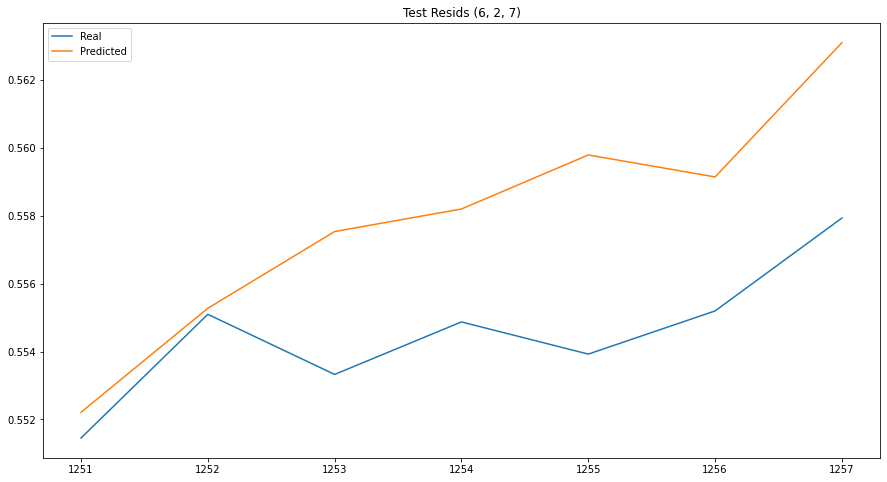

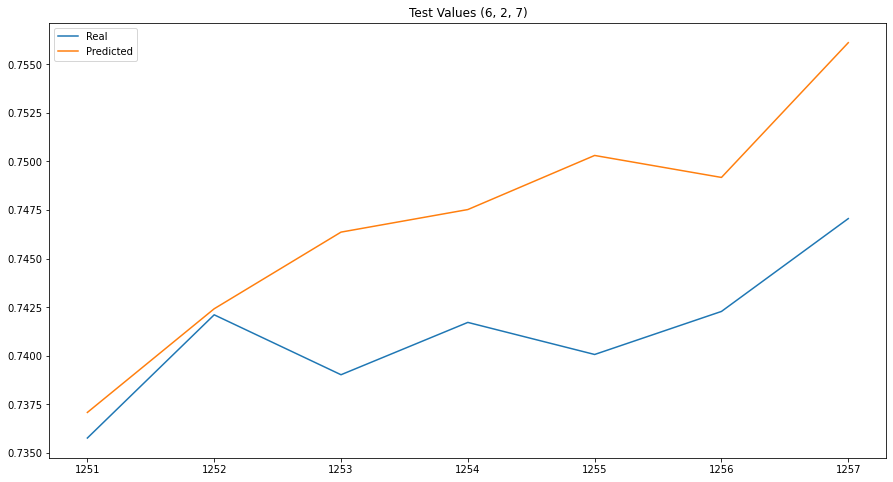

In [7]:
orders = [(7,1,5),(6,2,7)]

metrics_df_train = pd.DataFrame()
metrics_df_test = pd.DataFrame()

for t in range(2):

    for e, fold in enumerate(folds_indexes):

        metrics_train = pd.DataFrame()
        metrics_test = pd.DataFrame()

        train = series.iloc[fold[0]]
        test = series.iloc[fold[1]]

        model = ARIMA(train, order=orders[t])

        model_fit = model.fit()

        prediction = model_fit.forecast(test_size)
        prediction.index=test.index

        simple_plot(train[2:], model_fit.fittedvalues[2:], legend=['Real','Predicted'], title=f'Train Resids {orders[t]}', figsize=(15,8))

        simple_plot(np.exp(train[2:])-1, np.exp(model_fit.fittedvalues[2:])-1, legend=['Real','Predicted'], title=f'Train Values {orders[t]}', figsize=(15,8))

        simple_plot(test, prediction, legend=['Real','Predicted'], title=f'Test Resids {orders[t]}', figsize=(15,8))

        simple_plot(np.exp(test)-1, np.exp(prediction)-1, legend=['Real','Predicted'], title=f'Test Values {orders[t]}', figsize=(15,8))

        metrics_train = metrics_train.append(calculate_metrics(model_fit.fittedvalues, train),ignore_index=True)
        metrics_test = metrics_test.append(calculate_metrics(prediction, test),ignore_index=True)

        metrics_train['DW'] = durbin_watson(model_fit.resid)
        metrics_train['AIC'] = model_fit.aic
        metrics_train['BIC'] = model_fit.bic

        metrics_train['fold'] = e
        metrics_test['fold'] = e
        metrics_train['trend'] = t+1
        metrics_test['trend'] = t+1

        metrics_df_train = metrics_df_train.append(metrics_train)
        metrics_df_test = metrics_df_test.append(metrics_test.drop(columns=['R2']))


In [8]:
metrics_df_train.groupby(['trend']).mean().drop(columns=['fold'])

,MAE,MSE,R2,RMSE,RSS,DW,AIC,BIC
trend,,,,,,,,
1,0.004020,0.000088,0.991598,0.009404,0.108176,1.345699,-9203.942335,-9137.535161
2,0.004211,0.000104,0.990150,0.010182,0.126817,2.002294,-9160.528670,-9089.024713


In [9]:
metrics_df_test.groupby(['trend']).mean().drop(columns=['fold'])

,MAE,MSE,RMSE,RSS
trend,,,,
1,0.008492,0.000137,0.010114,0.000958
2,0.009107,0.000137,0.011076,0.000957


# ARCH

In [15]:
n_TR = 2
n_MA = 5
n_AR = 6

model = ARIMA(series, order=(n_AR, n_TR, n_MA))

model_fit = model.fit()

In [16]:
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

In [17]:
print('Breusch-Pagan Lagrange Multiplier test for heteroscedasticity')

Breusch-Pagan Lagrange Multiplier test for heteroscedasticity


In [23]:
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
pd.Series(dict(zip(
    labels, 
    het_breuschpagan(model_fit.resid[1:], series.diff(1)[1:].values.reshape(-1,1))
)))

LM Statistic       0.241749
LM-Test p-value         NaN
F-Statistic        0.241603
F-Test p-value     0.623137
dtype: float64

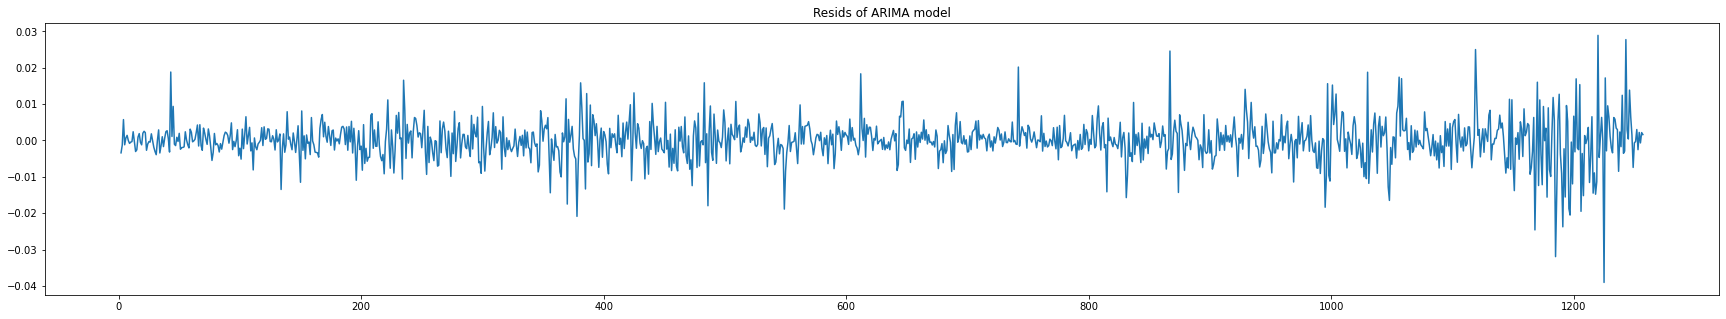

In [24]:
resid = model_fit.resid[2:]

plt.figure(figsize=(30, 5))
plt.title('Resids of ARIMA model')
resid.plot()
plt.show()

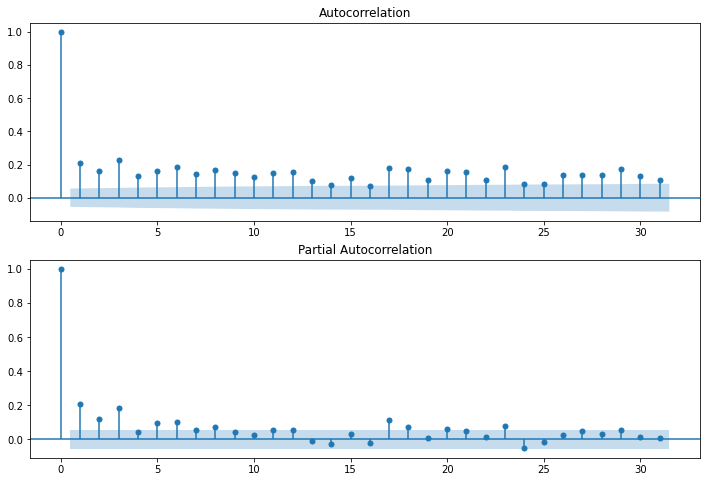

In [25]:
analyzed_resid = np.sqrt(resid ** 2)

fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(analyzed_resid, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(analyzed_resid, ax=ax2)

# ARCH

In [28]:
arch = arch_model(model_fit.resid[:-2], mean='HARX', vol='ARCH', p=3)
arch_fit = arch.fit()
clear_output(wait=True)

print(volatile_models_metrics(arch_fit))

{'AIC': -9564.39080769187, 'BIC': -9538.71237095673, 'R-squared': 0.0, 'DW': 1.9959818268458094}


# GARCH

In [29]:
garch = arch_model(model_fit.resid[:-2], mean='HARX', lags=100, vol='GARCH', p=3, q=1)
garch_fit = garch.fit()
clear_output(wait=True)

print(volatile_models_metrics(garch_fit))

{'AIC': -8688.308284414597, 'BIC': -8152.719853195971, 'R-squared': 0.11049502226421948, 'DW': 2.000751480228186}


# FIGARCH

In [31]:
figarch = arch_model(model_fit.resid[:-2], mean='HARX', lags=100, vol='Figarch', p=1, q=1)
figarch_fit = figarch.fit()
clear_output(wait=True)

print(volatile_models_metrics(figarch_fit))

{'AIC': -8698.635167290135, 'BIC': -8168.099457120741, 'R-squared': 0.10932840406101862, 'DW': 2.00105552436749}


# EGARCH

In [35]:
egarch = arch_model(model_fit.resid[:-2], mean='HARX', lags=100, vol='Egarch', p=2, q=1)
egarch_fit = egarch.fit()
clear_output(wait=True)

print(volatile_models_metrics(egarch_fit))

{'AIC': -8631.781408194453, 'BIC': -8101.245698025059, 'R-squared': -0.025096615080352214, 'DW': 1.9336488461338763}


# HS-forecast

In [38]:
print('Real value', model_fit.resid[-1:] ** 2)

arch_pred = arch_fit.forecast()
print('ARCH predict', arch_pred.variance[-1:].values[0][0])

garch_pred = garch_fit.forecast()
print('GARCH predict', garch_pred.variance[-1:].values[0][0])

figarch_pred = figarch_fit.forecast()
print('FIGARCH predict', figarch_pred.variance[-1:].values[0][0])

egarch_pred = egarch_fit.forecast()
print('EGARCH predict', egarch_pred.variance[-1:].values[0][0])

Real value 1257    0.000003
dtype: float64
ARCH predict 1.8251373618685284e-05
GARCH predict 2.6009998665357653e-05
FIGARCH predict 3.838774772749344e-05
EGARCH predict 3.57105494926086e-05
